In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<font color='red'>Prior to modelling the data, I will first take a look at cointegrated companies by comparing their adjusted close price. Firstly by checking that each companies adjusted close price follows a random walk and secondly checking for cointegration.</font>

In [2]:
aj = pd.read_csv('data/Adjusted close.csv')
aj.head()

,Date,Apple,Google,Hp,Microsoft,Sony
0,2010-01-04,26.419203,313.688690,18.160637,24.168472,27.184526
1,2010-01-05,26.464878,312.307312,18.236814,24.176279,27.057753
2,2010-01-06,26.043921,304.434448,18.067152,24.027906,27.030584
3,2010-01-07,25.995777,297.347351,18.074080,23.778025,26.985306
4,2010-01-08,26.168606,301.311310,18.209112,23.942017,27.537689


In [3]:
aj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2572 entries, 0 to 2571
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2572 non-null   object 
 1   Apple      2572 non-null   float64
 2   Google     2572 non-null   float64
 3   Hp         2572 non-null   float64
 4   Microsoft  2572 non-null   float64
 5   Sony       2572 non-null   float64
dtypes: float64(5), object(1)
memory usage: 120.7+ KB


In [4]:
# convert date column in aj into a datetime object

aj['Date'] = aj['Date'].apply(pd.to_datetime)
aj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2572 entries, 0 to 2571
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2572 non-null   datetime64[ns]
 1   Apple      2572 non-null   float64       
 2   Google     2572 non-null   float64       
 3   Hp         2572 non-null   float64       
 4   Microsoft  2572 non-null   float64       
 5   Sony       2572 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 120.7 KB


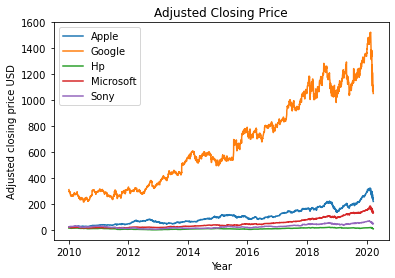

In [5]:
#plots of adjusted closing price for each compaany
for column in aj.columns[1:]:
    plt.plot('Date',column,data=aj)
_ = plt.title('Adjusted Closing Price')
_ = plt.xlabel('Year')
_ = plt.ylabel('Adjusted closing price USD')
plt.legend()
plt.show()

In [6]:
#firstly check to see that the adjusted closing price follows a random walk.
from statsmodels.tsa.stattools import adfuller

for column in aj.columns[1:]:
    result = adfuller(aj[column])
    print("The p-value for the ADF test on {} is {}".format(column,result[1]))

The p-value for the ADF test on Apple is 0.5154623180488823
The p-value for the ADF test on Google is 0.7264308153541197
The p-value for the ADF test on Hp is 0.41153994597512167
The p-value for the ADF test on Microsoft is 0.9946890919673206
The p-value for the ADF test on Sony is 0.8541331937209464


In [7]:
# set date as index
aj = aj.set_index('Date')
aj.head()

,Apple,Google,Hp,Microsoft,Sony
Date,,,,,
2010-01-04,26.419203,313.688690,18.160637,24.168472,27.184526
2010-01-05,26.464878,312.307312,18.236814,24.176279,27.057753
2010-01-06,26.043921,304.434448,18.067152,24.027906,27.030584
2010-01-07,25.995777,297.347351,18.074080,23.778025,26.985306
2010-01-08,26.168606,301.311310,18.209112,23.942017,27.537689


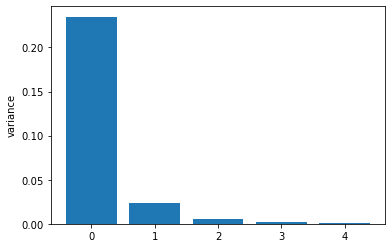

     0          1
0  PC1     Google
1  PC2         Hp
2  PC3     Google
3  PC4      Apple
4  PC5  Microsoft


In [8]:
# perform PCA on the data to analyse the less informative features

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import MinMaxScaler

new_df = aj[['Apple', 'Google', 'Hp', 'Microsoft', 'Sony']]
initial_feature_names = ['Apple', 'Google', 'Hp', 'Microsoft', 'Sony']

scaler = MinMaxScaler()
pca = PCA()

pipeline = make_pipeline(scaler,pca)
pipeline.fit(aj.values)

n_pcs = pca.components_.shape[0]


# to find out the most important features in order

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
df = pd.DataFrame(sorted(dic.items()))


features = range(pca.n_components_)

_ = plt.bar(features,pca.explained_variance_)
_ = plt.xticks(features)
_ = plt.ylabel('variance')

plt.show()
print(df)

<font color='red'> From the PCA, only google shows a significant amount of variance. Next I will perform the augmented adfuller test between each company and Microsoft to see if they are cointegrated.

In [9]:
#test to see cointegration between Google and Microsoft
import statsmodels.api as sm

MSFT = aj[['Microsoft']]
GOOGLE = aj[['Google']]

MSFT = sm.add_constant(MSFT)
result = sm.OLS(GOOGLE,MSFT).fit()

#value of the gradient 
const = result.params[1]
adf_g = adfuller(aj['Google'] - const*aj['Microsoft'])
print('Between Google and Microsoft')
print('The p-value for the ADF test is ', adf_g[1])

Between Google and Microsoft
The p-value for the ADF test is  0.7652989423827379


In [10]:
# test to see cointegration between Apple and Microsoft

APPLE = aj[['Apple']]

MSFT = sm.add_constant(MSFT)
result = sm.OLS(APPLE,MSFT).fit()

#value of the gradient 
const = result.params[1]
adf_a = adfuller(aj['Microsoft'] - const*aj['Apple'])
print('Between Apple and Microsoft')
print('The p-value for the ADF test is ', adf_a[1])

Between Apple and Microsoft
The p-value for the ADF test is  0.2965132352305258


In [11]:
# test to see cointegration between Microsoft and Hp

HP = aj[['Hp']]

MSFT = sm.add_constant(MSFT)
result = sm.OLS(HP,MSFT).fit()

#value of the gradient 
const = result.params[1]
adf_h = adfuller(aj['Hp'] - const*aj['Microsoft'])
print('Between Hp and Microsoft')
print('The p-value for the ADF test is ', adf_h[1])

Between Hp and Microsoft
The p-value for the ADF test is  0.2873156624411061


In [12]:
# test to see cointegration between Microsoft and Sony

SONY = aj[['Sony']]

MSFT = sm.add_constant(MSFT)
result = sm.OLS(SONY,MSFT).fit()

#value of the gradient 
const = result.params[1]
adf_s = adfuller(aj['Sony'] - const*aj['Microsoft'])
print('Between Sony and Microsoft')
print('The p-value for the ADF test is ', adf_s[1])

Between Sony and Microsoft
The p-value for the ADF test is  0.15472735293282103


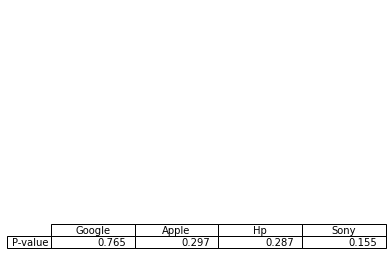

In [13]:
# cointegration values of each company compared with microsoft
from pandas.plotting import table

p_val_com = {'Google':[round(adf_g[1],3)],'Apple':[round(adf_a[1],3)],'Hp':[round(adf_h[1],3)],'Sony':[round(adf_s[1],3)]}
cointegration_df = pd.DataFrame(p_val_com,index=['P-value'])

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis


table(ax=ax,data=cointegration_df)
plt.savefig('adfuller.png')

<font color='red'> By comparing Microsoft with each company, no company shows a statistically significant cointegration value. From the results of the adfuller test and PCA, all features will be removed from the dataset.</font>

In [14]:
MSFT = MSFT.drop('const',1)
MSFT.head()

,Microsoft
Date,
2010-01-04,24.168472
2010-01-05,24.176279
2010-01-06,24.027906
2010-01-07,23.778025
2010-01-08,23.942017


<b> <font color='green'>PREPROCESSING</b> 

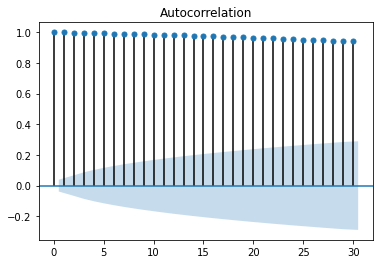

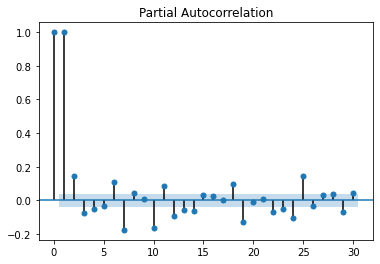

In [15]:
#ACF : ckecks to see if there is a the previos time step has an impact on the next time step
#PCF : see which lag has an impact on the next time step.
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

_ = plot_acf(MSFT['Microsoft'],lags=30)
plt.savefig('ACF.png')
_ = plot_pacf(MSFT['Microsoft'],lags=30)
plt.savefig('PACF.png')

In [16]:
shift_days = 1
forecast_days = 30
MSFT['predictions'] = MSFT['Microsoft'].shift(-shift_days)

In [17]:
MSFT = MSFT.dropna()

In [18]:
MSFT.tail()

,Microsoft,predictions
Date,,
2020-03-16,134.718231,145.810471
2020-03-17,145.810471,139.672424
2020-03-18,139.672424,141.970474
2020-03-19,141.970474,136.638245
2020-03-20,136.638245,135.275345


In [19]:
X,y = MSFT[['Microsoft']].values, MSFT[['predictions']].values
X_train,X_test = MSFT[['Microsoft']].values[:-forecast_days], MSFT[['Microsoft']].values[-forecast_days:]

y_train,y_test = MSFT[['predictions']].values[:-forecast_days], MSFT[['predictions']].values[-forecast_days:]

<b> <font color='green'>----------MODELLING-----------</b> 

<font color='red'> For the modelling section, I will cover Linear Regression, XGBoost and LSTM. For each model the hyperparameters will be tuned and a metrics will be calculated to determine if the model is able to make an accurate prediction on unseen data.</font>


<font color='blue'> Linear Regression</font>


In [69]:
# first model will be multiple linear regression 
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline 

LR = LinearRegression()
PF = PolynomialFeatures()
time_splitter_inner = TimeSeriesSplit(n_splits=5)


steps = [('poly',PF),
         ('lin_reg',LR)]

pipeline = Pipeline(steps)
params = {'poly__degree':[1,2,3,4]}

gs_cv = GridSearchCV(pipeline, param_grid=params,
                     scoring='neg_mean_absolute_error', 
                     cv=time_splitter_inner, verbose=1)

gs_cv.fit(X_train,y_train)

print("Best parameters found: ", gs_cv.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(gs_cv.best_score_)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'poly__degree': 1}
Lowest RMSE found:  0.7714233492024322


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


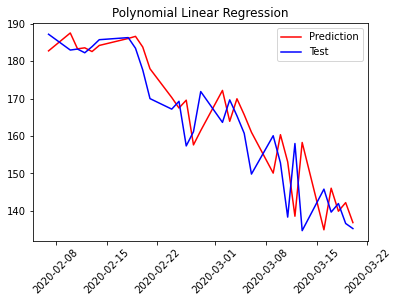

In [74]:
LR = LinearRegression()
PF = PolynomialFeatures(degree=1)

steps = [('poly',PF),
        ('lin_reg',LR)]

pipeline = Pipeline(steps)
pipeline.fit(X_train,y_train)
lr_y_pred = pipeline.predict(X_test)


test_range = MSFT[['Microsoft']][-forecast_days:].index
#lr_y_pred_s = pd.Series(lr_y_pred).shift(-1)
#ex = pd.Series(np.reshape(lr_y_pred,len(lr_y_pred))).shift(-1)

_ = plt.plot(test_range,lr_y_pred,label= 'Prediction',color='red')
_ = plt.plot(test_range,y_test,label= 'Test',color='blue')
_ = plt.xticks(rotation=45)
_ = plt.title('Polynomial Linear Regression')
_ = plt.legend()
plt.savefig('Linear.png',bbox_inches='tight')




In [76]:
#metrics MAE,RMSE
from sklearn.metrics import mean_absolute_error,mean_squared_error, accuracy_score


print('Mean Absolute Error: ',mean_absolute_error(y_test,lr_y_pred))
print('Root Mean Squared Error: ',np.sqrt(mean_squared_error(y_test,lr_y_pred)))

Mean Absolute Error:  6.618550946824555
Root Mean Squared Error:  8.605275334267825


<font color='blue'> XGBoost</font>


In [26]:
MSFT.head()

,Microsoft,predictions
Date,,
2010-01-04,24.168472,24.176279
2010-01-05,24.176279,24.027906
2010-01-06,24.027906,23.778025
2010-01-07,23.778025,23.942017
2010-01-08,23.942017,23.637472


In [27]:
X_xgb = MSFT.Microsoft.values.reshape(-1,1)
y_xgb = MSFT.predictions.values.reshape(-1,1)

In [28]:
# create a Randomized search to find optimal hyper-parameters
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

gbm_param_grid = {
    'colsample_bytree': np.arange(0,0.5,0.01),
    'n_estimators': np.arange(100,1600,100),
    'max_depth': np.arange(1,20),
    'learning_rate':np.arange(0,1,0.05),
    'subsample':np.arange(0,0.5,0.01)
}

gbm = xgb.XGBRegressor()

rs_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, 
                              n_iter=60,scoring='neg_root_mean_squared_error', 
                              cv=time_splitter_inner, verbose=1, n_jobs=-1)

rs_mse.fit(X_xgb,y_xgb)

print("Best parameters found: ", rs_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(rs_mse.best_score_)))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   34.3s finished


Best parameters found:  {'subsample': 0.03, 'n_estimators': 500, 'max_depth': 16, 'learning_rate': 0.5, 'colsample_bytree': 0.37}
Lowest RMSE found:  3.750441055985575


In [53]:
# transform a time series dataset into a supervised learning dataset
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = xgb.XGBRegressor(colsample_bytree = 0.01,
                              n_estimators = 200,
                              max_depth = 15,
                              learning_rate = 0.35,
                              subsample = 0.07)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = []
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
    # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
    # store forecast in list of predictions
        predictions.append(yhat)
    # add actual observation to history for the next loop
        history.append(test[i])
    # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [54]:
msft = aj['Microsoft'].to_frame()
msft.head()

,Microsoft
Date,
2010-01-04,24.168472
2010-01-05,24.176279
2010-01-06,24.027906
2010-01-07,23.778025
2010-01-08,23.942017


In [55]:
mm = msft.values

In [56]:
data =  series_to_supervised(mm,n_in=6)
mae, y, yhat = walk_forward_validation(data, 30)
print('MAE: %.3f' % mae)

>expected=187.2, predicted=182.0
>expected=183.0, predicted=185.9
>expected=183.3, predicted=185.6
>expected=182.3, predicted=184.5
>expected=183.9, predicted=183.5
>expected=185.8, predicted=183.8
>expected=186.3, predicted=183.6
>expected=183.5, predicted=184.2
>expected=177.7, predicted=182.6
>expected=170.0, predicted=183.3
>expected=167.2, predicted=178.5
>expected=169.3, predicted=167.5
>expected=157.4, predicted=175.0
>expected=161.2, predicted=156.6
>expected=171.9, predicted=171.7
>expected=163.7, predicted=175.9
>expected=169.7, predicted=161.5
>expected=165.4, predicted=167.1
>expected=160.7, predicted=169.7
>expected=149.8, predicted=172.2
>expected=160.1, predicted=173.9
>expected=152.8, predicted=163.7
>expected=138.3, predicted=179.6
>expected=158.0, predicted=169.2
>expected=134.7, predicted=155.7
>expected=145.8, predicted=152.5
>expected=139.7, predicted=152.2
>expected=142.0, predicted=147.4
>expected=136.6, predicted=150.0
>expected=135.3, predicted=159.8
MAE: 9.533

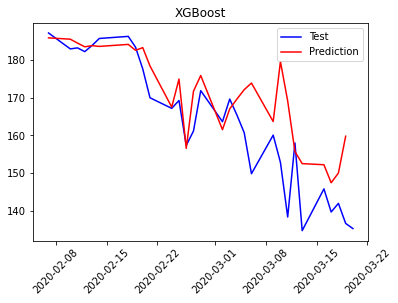

In [72]:
yhat_s = pd.Series(yhat).shift(-1)

plt.plot(test_range,y, label='Test',color='blue')
plt.plot(test_range,yhat_s, label= 'Prediction',color='red')
plt.title('XGBoost')
plt.xticks(rotation=45)
plt.legend()
plt.savefig('xgb.png',bbox_inches='tight')
plt.show()


In [58]:
type(yhat)

list

In [75]:
yhat_ss = np.array(yhat_s)[:-1]
y_ss = y[:-1]


print('Mean Absolute Error: ',mean_absolute_error(y_ss,yhat_ss))
print('Root Mean Squared Error: ',np.sqrt(mean_squared_error(y_ss,yhat_ss)))

Mean Absolute Error:  7.523787925983299
Root Mean Squared Error:  11.340097300397995


<font color='blue'> ARIMA</font>


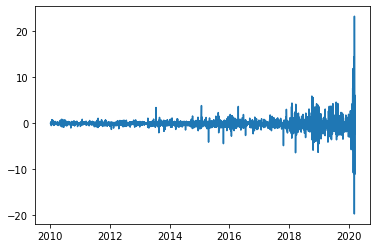

In [36]:
# convert to stationarity- mean,variance and covaraince is constant over periods
plt.plot(MSFT['Microsoft'].diff(-1))


In [37]:
#create stationarity
difference = MSFT[['Microsoft']].diff(-1)


In [38]:
#drop missing values 
difference = difference.dropna()

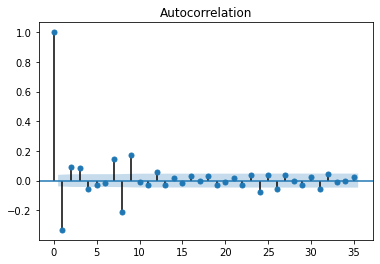

In [39]:
_ = plot_acf(difference)

In [40]:
test_size = 30

X = MSFT[['Microsoft']] 

train = X[:-test_size]
test = X[-test_size:]

training_data = train['Microsoft'].values.reshape(-1,1)
testing_data = test['Microsoft'].values.reshape(-1,1)


In [41]:
from statsmodels.tsa.arima_model import ARIMA
#p: periods taken for autoregressive model
#d: order of integration
#q: periods in moving average model 


In [ ]:
#Armia model


warnings.filterwarnings('ignore')
p = [x for x in range(5)]
d=q = [0,1,2]
pdq = list(itertools.product(p,d,q))
results = {}

def evaluate_arima_model(train,test,arima_order):
    history = [x for x in train]
    model_predictions = []
    N_test_observations = len(test)

    for time_point in range(N_test_observations):
        model = ARIMA(history,order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        model_predictions.append(yhat)
        true_test_value = testing_data[time_point]
        history.append(true_test_value)
    
    MSE_error = mean_squared_error(testing_data,model_predictions)
    return MSE_error
    

for param in pdq:
    try:
        param_mse = evaluate_arima_model(training_data,testing_data,param)
        results[param] = param_mse
    except:
        continue


In [42]:
results_df = pd.DataFrame(list(results.items()),columns=['ARIMA Parameters','MSE'])

NameError: name 'results' is not defined

In [ ]:
results_df[results_df.MSE == results_df.MSE.min()]

In [49]:
import itertools
import warnings
warnings.filterwarnings('ignore')

history = [x for x in training_data]
arima_model_predictions = []
N_test_observations = len(testing_data)

for time_point in range(N_test_observations):
    model = ARIMA(history,order=(2,2,1))
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output[0]
    arima_model_predictions.append(yhat)
    true_test_value = testing_data[time_point]
    history.append(true_test_value)
    

MSE_error = mean_squared_error(testing_data,arima_model_predictions)
print(MSE_error)


63.48365453111167


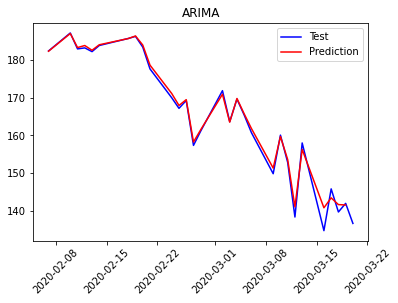

pandas.core.series.Series

In [73]:
test_set_range = test['Microsoft'].index

arima_model_pred_s = pd.Series(arima_model_predictions).shift(-1)

plt.plot(test_set_range,testing_data,color='blue',label='Test')
plt.plot(test_set_range,arima_model_pred_s,color='red',label='Prediction')
plt.title('ARIMA')
plt.xticks(rotation=45)
plt.legend()
plt.savefig('ARIMA.png',bbox_inches='tight')
plt.show()


In [51]:
#arima_model_pred_s.dropna(inplace=True)
arima_model_pred_sr = np.array(arima_model_pred_s)[:-1]
y_test_r = y_test[:-1]
#print(arima_model_pred_s)
print(len(arima_model_pred_sr))
print(len(y_test_r))

print('Mean Absolute Error: ',mean_absolute_error(y_test_r,arima_model_pred_sr))
print('Root Mean Squared Error: ',np.sqrt(mean_squared_error(y_test_r,arima_model_pred_sr)))


29
29
Mean Absolute Error:  6.2432363558988495
Root Mean Squared Error:  8.103648589614714
